# HGX — Dataset Stats & Motifs (choose a dataset)

This notebook is inspired by the official **HGX tutorials** and guides a basic end‑to‑end analysis:

- **Load** a dataset with `load_hypergraph(...)`.
- Compute and plot the **node degree (hyperdegree) distribution** and **hyperedge size distribution** using HGX.
- Compute **hypergraph motifs** via the HGX **motifs** API.


In [1]:
# 0) Imports
from hypergraphx.readwrite import load_hypergraph
from hypergraphx.core.hypergraph import Hypergraph
from hypergraphx.viz.draw_hypergraph import draw_hypergraph
from hypergraphx.representations.projections import clique_projection
from hypergraphx.motifs import compute_motifs

import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
import os, json

In [2]:
# 1) Choose a dataset (edit this path)
#    Examples if you use your repo layout:
#    'datasets/NDC-classes.json', 'datasets/coauth-cs-NeurIPS.json', 'datasets/contacts-high-school.json'
DATASET_PATH = '../datasets/contacts-high-school.json'

# Load the hypergraph
hg = load_hypergraph(DATASET_PATH)
print(hg)

Hypergraph with 327 nodes and 7818 edges.
Distribution of hyperedge sizes: {2: 5498, 3: 2091, 4: 222, 5: 7}


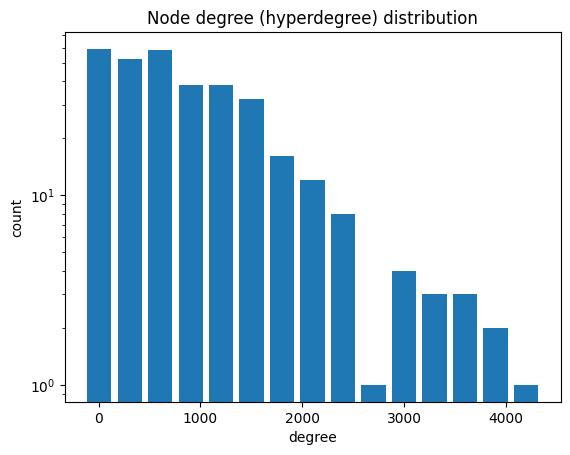

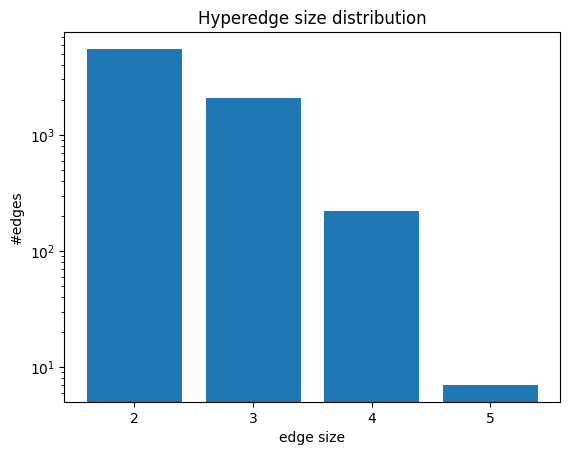

In [3]:
# 2) Degree distribution (hyperdegree) and hyperedge size distribution via HGX

# Node degrees (hyperdegree): if your HGX exposes a degree for each node
degrees = [hg.degree(u) for u in hg.get_nodes()]

plt.figure()
plt.yscale('log')
plt.hist(degrees, bins=15, align='left', rwidth=0.8)

plt.title("Node degree (hyperdegree) distribution")
plt.xlabel("degree"); plt.ylabel("count")
plt.show()

# Hyperedge size distribution (HGX provides distribution_sizes())
sizes = dict(sorted(hg.distribution_sizes().items()))

plt.figure()
plt.yscale('log')
plt.bar([str(k) for k in sizes.keys()], list(sizes.values()))
plt.title("Hyperedge size distribution")
plt.xlabel("edge size"); plt.ylabel("#edges")
plt.show()

Projection: |V| = 327 |E| = 5818


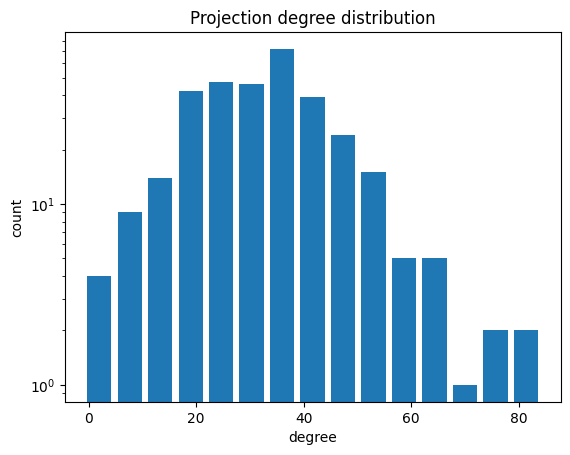

In [4]:
# 3) Projection (2‑clique) and quick look at projected degrees
G = clique_projection(hg, keep_isolated=False)  # expected to return a networkx.Graph

print("Projection: |V| =", G.number_of_nodes(), "|E| =", G.number_of_edges())

proj_deg = [d for _, d in G.degree()]
plt.figure()
plt.yscale('log')
plt.hist(proj_deg, bins=15, align='left', rwidth=0.8)

plt.title("Projection degree distribution")
plt.xlabel("degree"); plt.ylabel("count")
plt.show()

Motifs are small recurring patterns of subgraphs that are overrepresented in a network. Motif analysis has established itself as a fundamental tool in network science to describe networked systems at their microscale, identifying their structural and functional building blocks. We provide an implementation for higher-order motif analysis, extracting overabundant subgraphs of nodes connected by higher-order interactions, as originally defined in *Lotito, Q.F., Musciotto, F., Montresor, A. et al. Higher-order motif analysis in hypergraphs. Commun Phys 5, 79 (2022).*

The function *compute_motifs* accepts the hypergraph hg as a parameter, the order of the motif analysis (i.e., the size of the patterns in terms of the number of nodes), and the runs of the configuration model for computing the score of the motifs (relative abundance). Zero runs of the configuration model corresponds to counting patterns in the input hypergraphs. For example, here we set first zero, then five runs for the configuration model. Five runs is a very low number, but it is enough for the purpose of this tutorial.

In [5]:
motifs = compute_motifs(hg, order=3, runs_config_model=0)
motifs = motifs['observed']

# print in descending order, motifs is a list of tuples (motif, count)
motifs = sorted(motifs, key=lambda x: x[1], reverse=True)
print("Motifs (order 3) and their counts:")
for motif, count in motifs:
    print(f"Motif: {motif}, Count: {count}")

Computing observed motifs of order 3...
Motifs (order 3) and their counts:
Motif: ((1, 2), (1, 3)), Count: 115709
Motif: ((1, 2), (1, 3), (2, 3)), Count: 28029
Motif: ((1, 2), (1, 2, 3), (1, 3), (2, 3)), Count: 1802
Motif: ((1, 2), (1, 2, 3), (1, 3)), Count: 231
Motif: ((1, 2), (1, 2, 3)), Count: 58
Motif: ((1, 2, 3),), Count: 0


In [6]:
motifs = compute_motifs(hg, order=3, runs_config_model=5)

Computing observed motifs of order 3...
Computing config model motifs of order 3. Step: 1
75890 steps completed.
Computing config model motifs of order 3. Step: 2
75890 steps completed.
Computing config model motifs of order 3. Step: 3
75890 steps completed.
Computing config model motifs of order 3. Step: 4
75890 steps completed.
Computing config model motifs of order 3. Step: 5
75890 steps completed.


The output object stores the count of the patterns on the input hypergraph, the count of the patterns on the samples from the configuration model and the relative abundance score of the motifs.

In [7]:
print(motifs.keys())

dict_keys(['observed', 'config_model', 'norm_delta'])


In [8]:
motif_profile = [i[1] for i in motifs['norm_delta']]

Let's plot the profile. Please keep in mind that the x-axis of the plot follows the original paper convention, displaying first the patterns involving lower-order interactions only.

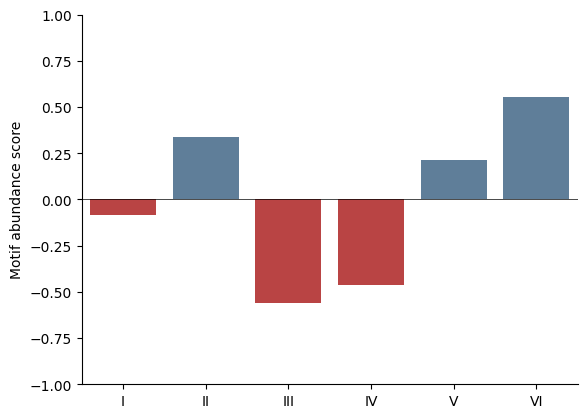

In [9]:
from hypergraphx.viz import plot_motifs
plot_motifs(motif_profile)

# Methods for defining the mesoscale structure of higher-order networks

Here we show a variety of approaches for defining the mesoscale structure of higher-order networks. 
1) We provide an implementation of a spectral method, that we call **Hypergraph Spectral Clustering**, which recovers hard communities via hypergraph cut optimization: ["_Learning with hypergraphs: Clustering, classification, and embedding", Zhou D., Huang J., Schölkopf B._](https://proceedings.neurips.cc/paper/2006/file/dff8e9c2ac33381546d96deea9922999-Paper.pdf)

2) We also implement different generative models able to extract overlapping communities and jointly infer hyperedges (**Hypergraph-MT**), allowing to capture a variety of mesoscale organizations, including both disassortative and assortative community structure (**Hy-MMSBM**): [_"Inference of hyperedges and overlapping communities in hypergraphs", Contisciani M., Battiston F., De Bacco_](https://www.nature.com/articles/s41467-022-34714-7) and [_"Generalized inference of mesoscale structures in higher-order networks", Ruggeri N., Contisciani M., Battiston F., De Bacco C._](https://arxiv.org/abs/2301.11226)

In [10]:
from hypergraphx.utils import normalize_array, calculate_permutation_matrix
from hypergraphx.communities.hy_sc.model import HySC
from hypergraphx.communities.hypergraph_mt.model import HypergraphMT
from hypergraphx.communities.hy_mmsbm.model import HyMMSBM
from hypergraphx.viz import draw_communities

In [11]:
K = 5  # number of communities
seed = 2025  # random seed
n_realizations = 10  # number of realizations with different random initialization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
cmap = sns.color_palette("Paired", desat=0.7)
col = {k: matplotlib.colors.to_hex(cmap[k*2], keep_alpha=False) for k in np.arange(K)}

In [12]:
model = HySC(
    seed=seed, 
    n_realizations=n_realizations
)
u_HySC = model.fit(
    hg, 
    K=K, 
    weighted_L=False
)

<Figure size 1400x1400 with 0 Axes>

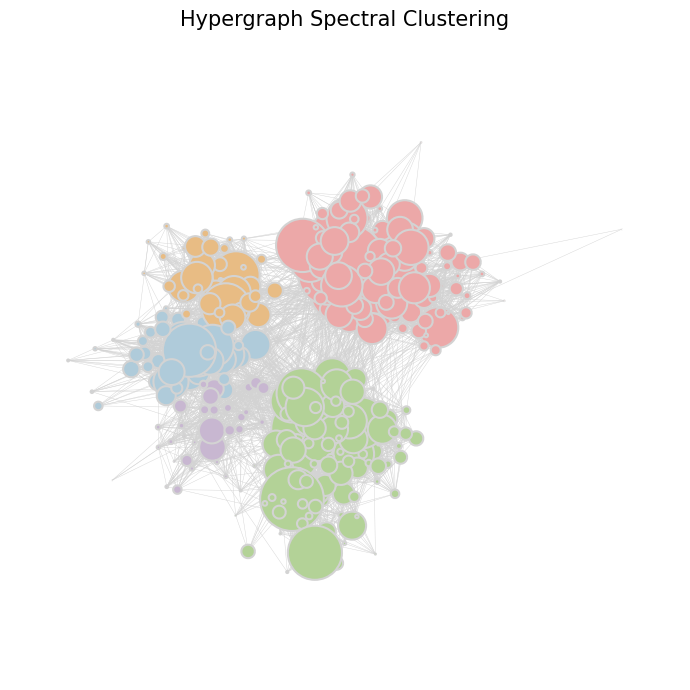

In [13]:
plt.figure(figsize=(14,14))

draw_communities(hypergraph=hg, c_node_size=0.00005, col=col, u=u_HySC, with_node_labels=False, title='Hypergraph Spectral Clustering')


In [14]:
import random 
np.random.seed(2025)
random.seed(2025)
    
# Train some models with different random initializations, choose the best one in terms of likelihood
best_model = None
best_loglik = float("-inf")
for j in range(n_realizations):
    model = HyMMSBM(
        K=K, 
        assortative=True
    )
    model.fit(
        hg, 
        n_iter=100
    )

    log_lik = model.log_likelihood(hg)
    if log_lik > best_loglik:
        best_model = model
        best_loglik = log_lik

u_HyMMSBM = best_model.u
w_HyMMSBM = best_model.w

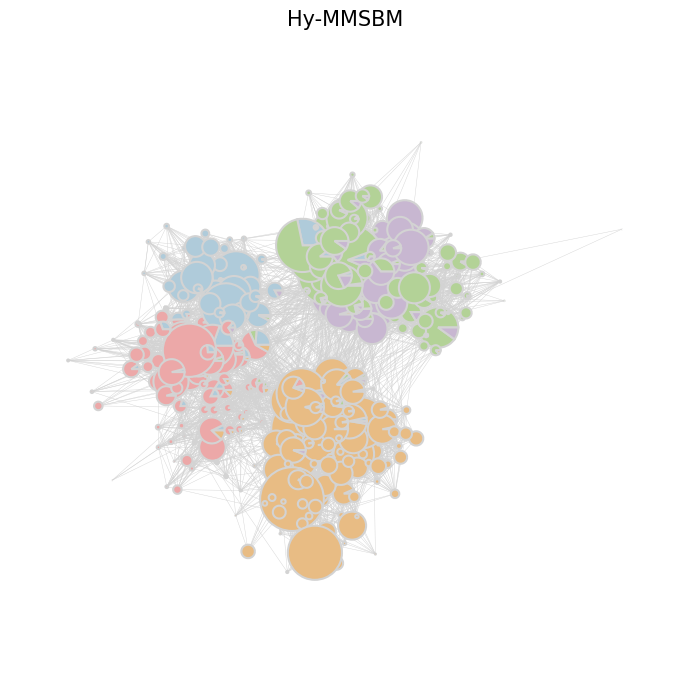

In [15]:
draw_communities(hypergraph=hg, u=u_HyMMSBM, c_node_size=0.00005, col=col, with_node_labels=False, title='Hy-MMSBM')